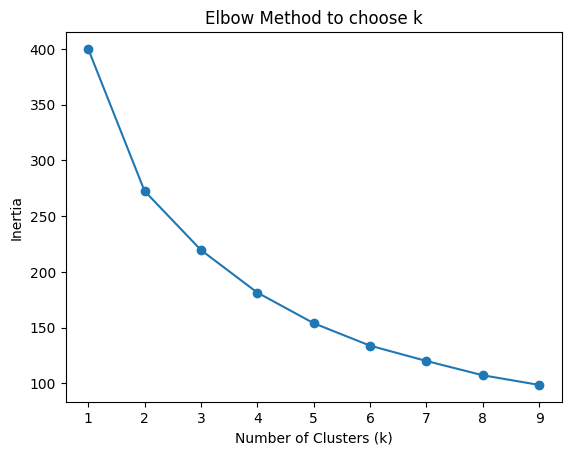

Cluster centers (unscaled):
   daily_screen_time  session_duration  app_switches  night_activity
0         187.333333         87.259259     29.666667       28.962963
1         489.081081         69.783784     45.891892      142.594595
2         244.194444         32.527778     44.027778       49.000000
   daily_screen_time  session_duration  app_switches  night_activity  \
0                545                48            77             214   
1                464                75            78             224   
2                494                93            28              85   
3                570               118            38             181   
4                312                59            22              73   

  usage_group  
0       heavy  
1       heavy  
2       heavy  
3       heavy  
4    moderate  


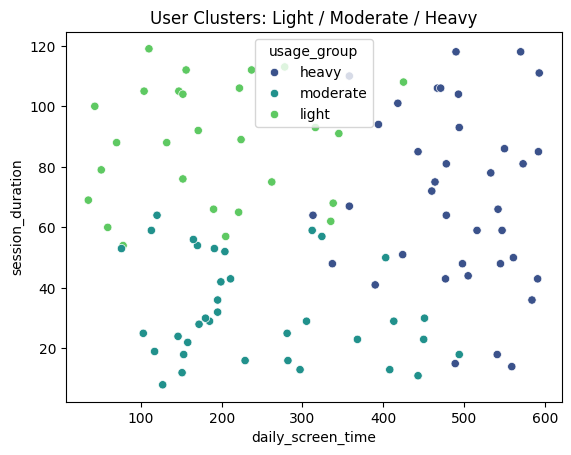

✅ KMeans model and scaler saved in ../trained_models/


In [1]:
# Train, evaluate, and save a K-Means clustering model
# for grouping users into light, moderate, heavy usage patterns.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


# 1. Load Dataset
df = pd.read_csv("../preprocessing/expanded_dataset.csv")

# Features for clustering (no labels used in unsupervised learning)
X = df[['daily_screen_time', 'session_duration', 'app_switches', 'night_activity']]


# 2. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 3. Choose Optimal K (Elbow Method)
inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method to choose k")
plt.show()


# 4. Train KMeans with k=3 (light, moderate, heavy)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)


# 5. Inspect Cluster Centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns)
print("Cluster centers (unscaled):")
print(centers_df)

# 6. Map Clusters to Usage Groups
# We’ll use daily_screen_time to rank clusters
cluster_labels = { 
    np.argmin(centers[:, 0]): "light",      # lowest screen time
    np.argsort(centers[:, 0])[1]: "moderate",
    np.argmax(centers[:, 0]): "heavy"
}

df["usage_group"] = df["cluster"].map(cluster_labels)

# Preview results
print(df[["daily_screen_time", "session_duration", "app_switches", "night_activity", "usage_group"]].head())


# 7. Visualize Clusters (optional)
sns.scatterplot(
    x="daily_screen_time", y="session_duration", 
    hue="usage_group", data=df, palette="viridis"
)
plt.title("User Clusters: Light / Moderate / Heavy")
plt.show()


# 8. Save Models
trained_dir = os.path.join("..", "trained_models")
os.makedirs(trained_dir, exist_ok=True)

joblib.dump(kmeans, "../trained_models/kmeans_usage_cluster.pkl")
joblib.dump(scaler, "../trained_models/kmeans_usage_scaler.pkl")


print("✅ KMeans model and scaler saved in ../trained_models/")
